<a href="https://colab.research.google.com/github/MichailLepin/Fake-News-Classifier/blob/main/notebooks/cnn_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN Model Training for Fake News Classification

This notebook contains code for training a CNN model for fake news classification in Google Colab.

## Notebook Structure

1. **Install Dependencies** - Install required libraries
2. **Imports** - Import all necessary modules
3. **Load and Process Data** - Load ISOT/Kaggle dataset and preprocessing
4. **Build Vocabulary and Tokenization** - Build vocabulary and convert text to sequences
5. **Load GloVe Embeddings** - Load pre-trained word embeddings
6. **PyTorch Dataset** - Create datasets for training
7. **CNN Model** - Define CNN architecture
8. **Training Functions** - Functions for training and evaluating the model
9. **Training** - Model training process
10. **Test Set Evaluation** - Final model evaluation



## Install Dependencies

Install all required libraries for PyTorch, data processing, and visualization.


In [17]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install scikit-learn pandas numpy matplotlib seaborn tqdm
!pip install kagglehub



Looking in indexes: https://download.pytorch.org/whl/cu118


## Imports

Import all necessary libraries and modules for data processing, models, and metrics.


In [18]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Проверка GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if torch.cuda.is_available():
    print(f'GPU: {torch.cuda.get_device_name(0)}')
    print(f'Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB')



Using device: cpu


## Load and Process Data

Load ISOT/Kaggle dataset from Kaggle and perform preprocessing:
- Load Fake.csv and True.csv via kagglehub
- Text cleaning (lowercase, URL removal, whitespace normalization)
- Create binary labels
- Stratified train/validation/test split (64%/16%/20%)


In [19]:
import re
import kagglehub

# Download dataset via kagglehub (no API keys required)
path = kagglehub.dataset_download("clmentbisaillon/fake-and-real-news-dataset")

# Load data
fake_df = pd.read_csv(f"{path}/Fake.csv")
true_df = pd.read_csv(f"{path}/True.csv")

print(f"✓ Fake news loaded: {fake_df.shape}")
print(f"✓ True news loaded: {true_df.shape}")

# Text cleaning function (from analyze_and_integrate.py script)
def clean_text(text):
    """Clean text: lowercase, remove URLs, normalize whitespace"""
    if pd.isna(text):
        return ""
    text = str(text)
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    return text

# Identify text column
text_col = None
for col in fake_df.columns:
    if fake_df[col].dtype == 'object' and col.lower() in ['text', 'title', 'article']:
        text_col = col
        break
if text_col is None:
    text_col = fake_df.select_dtypes(include=['object']).columns[0]

print(f"\nUsing column: '{text_col}'")

# Add labels
fake_df['label'] = 'fake'
true_df['label'] = 'real'

# Combine data
combined_data = pd.concat([fake_df, true_df], ignore_index=True)

# Clean text
print("\nCleaning text...")
combined_data['text_cleaned'] = combined_data[text_col].apply(clean_text)

# Create binary labels
combined_data['label_binary'] = combined_data['label'].map({'fake': 1, 'real': 0})

# Remove empty texts
combined_data = combined_data[
    combined_data['text_cleaned'].notna() &
    (combined_data['text_cleaned'].str.len() > 0)
]

print(f"\nCombined dataset: {combined_data.shape}")
print(f"Label distribution: {combined_data['label'].value_counts().to_dict()}")

# Split into train/val/test with stratification
X = combined_data['text_cleaned'].values
y = combined_data['label_binary'].values

# First split: train+val (80%) and test (20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Second split: train (64%) and val (16%)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.2, random_state=42, stratify=y_train_val
)

print(f"\nData split:")
print(f"  Train: {len(X_train):,} ({len(X_train)/len(combined_data)*100:.1f}%)")
print(f"  Validation: {len(X_val):,} ({len(X_val)/len(combined_data)*100:.1f}%)")
print(f"  Test: {len(X_test):,} ({len(X_test)/len(combined_data)*100:.1f}%)")


Using Colab cache for faster access to the 'fake-and-real-news-dataset' dataset.
✓ Fake news loaded: (23481, 4)
✓ True news loaded: (21417, 4)

Using column: 'title'

Cleaning text...

Combined dataset: (44889, 7)
Label distribution: {'fake': 23472, 'real': 21417}

Data split:
  Train: 28,728 (64.0%)
  Validation: 7,183 (16.0%)
  Test: 8,978 (20.0%)


## Build Vocabulary and Tokenization

Build vocabulary from training data and functions to convert text to index sequences.


In [20]:
def build_vocab(texts, min_freq=2):
    """Build vocabulary from texts"""
    word_counts = Counter()
    for text in texts:
        words = str(text).lower().split()
        word_counts.update(words)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2

    for word, count in word_counts.items():
        if count >= min_freq:
            vocab[word] = idx
            idx += 1

    return vocab

def text_to_sequence(text, vocab, max_len=256):
    """Convert text to sequence of indices"""
    words = str(text).lower().split()
    sequence = [vocab.get(word, vocab['<UNK>']) for word in words[:max_len]]

    if len(sequence) < max_len:
        sequence.extend([vocab['<PAD>']] * (max_len - len(sequence)))

    return sequence[:max_len]

# Build vocabulary
print("\nBuilding vocabulary...")
vocab = build_vocab(X_train, min_freq=2)
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")

# Model parameters
MAX_LEN = 256
EMBEDDING_DIM = 100



Building vocabulary...
Vocabulary size: 18321


## Save Vocabulary

Save the vocabulary to a JSON file for use in the backend API.

In [21]:
# Save vocabulary for backend use
import json
import os
from google.colab import files

# Check if vocab exists - try multiple ways to find it
vocab_found = False
vocab_to_save = None

# Method 1: Check globals
if 'vocab' in globals():
    vocab_to_save = globals()['vocab']
    vocab_found = True
# Method 2: Check if vocab_size exists and try to rebuild
elif 'vocab_size' in globals() and 'X_train' in globals():
    print("⚠ Vocab variable not found, but vocab_size exists.")
    print("Attempting to rebuild vocabulary from training data...")
    from collections import Counter

    def build_vocab(texts, min_freq=2):
        """Build vocabulary from texts"""
        word_counts = Counter()
        for text in texts:
            words = str(text).lower().split()
            word_counts.update(words)
        vocab = {'<PAD>': 0, '<UNK>': 1}
        idx = 2
        for word, count in word_counts.items():
            if count >= min_freq:
                vocab[word] = idx
                idx += 1
        return vocab

    vocab_to_save = build_vocab(X_train, min_freq=2)
    vocab_found = True
    print(f"✓ Vocabulary rebuilt! Size: {len(vocab_to_save)}")
else:
    print("❌ ERROR: Vocabulary not found!")
    print("\nTo fix this:")
    print("1. Make sure you have executed the 'Build Vocabulary and Tokenization' cell (Cell 9)")
    print("2. The cell should create a variable called 'vocab'")
    print("3. Check that the cell executed without errors")
    print("\nIf the cell was executed, try running it again.")
    raise NameError("Variable 'vocab' not found. Please execute the 'Build Vocabulary and Tokenization' cell first.")

if vocab_found and vocab_to_save:
    print(f"✓ Vocab found! Size: {len(vocab_to_save)}")

    # Create directory
    os.makedirs('vocab', exist_ok=True)

    # Save vocab to JSON
    vocab_path = 'vocab/vocab.json'
    with open(vocab_path, 'w', encoding='utf-8') as f:
        json.dump(vocab_to_save, f, ensure_ascii=False, indent=2)

    print(f"✓ Vocab saved to {vocab_path}")

    # Download the file
    files.download(vocab_path)

    print("\n" + "="*60)
    print("✓ FILE DOWNLOADED!")
    print("="*60)
    print("\nNext steps:")
    print("1. The vocab.json file should be downloaded to your Downloads folder")
    print("2. Copy it to the vocab/ folder in your project")
    print("3. The path should be: Fake-News-Classifier-2/vocab/vocab.json")
    print("\nVocab structure check:")
    print(f"  - <PAD>: {vocab_to_save.get('<PAD>', 'NOT FOUND')}")
    print(f"  - <UNK>: {vocab_to_save.get('<UNK>', 'NOT FOUND')}")
    print(f"  - Total words: {len(vocab_to_save)}")

✓ Vocab found! Size: 18321
✓ Vocab saved to vocab/vocab.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ FILE DOWNLOADED!

Next steps:
1. The vocab.json file should be downloaded to your Downloads folder
2. Copy it to the vocab/ folder in your project
3. The path should be: Fake-News-Classifier-2/vocab/vocab.json

Vocab structure check:
  - <PAD>: 0
  - <UNK>: 1
  - Total words: 18321


In [22]:
# This is a duplicate cell - you can delete it or ignore it
# Use the cell above (Cell 11) to save vocabulary
print("This cell is a duplicate. Please use Cell 11 above to save vocabulary.")


This cell is a duplicate. Please use Cell 11 above to save vocabulary.


## Load GloVe Embeddings

Load pre-trained GloVe embeddings (GloVe 6B.100d) to initialize the model's embedding layer.


In [23]:
def load_glove_embeddings(glove_path, vocab, embedding_dim=100):
    """Load pre-trained GloVe embeddings"""
    print(f"Loading GloVe embeddings from {glove_path}...")

    if not os.path.exists(glove_path):
        print("Downloading GloVe 6B.100d...")
        !wget -q http://nlp.stanford.edu/data/glove.6B.zip
        !unzip -q glove.6B.zip

    embeddings_index = {}
    with open(glove_path, 'r', encoding='utf-8') as f:
        for line in tqdm(f, desc="Loading GloVe"):
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    found = 0

    for word, idx in vocab.items():
        if word in embeddings_index:
            embedding_matrix[idx] = embeddings_index[word]
            found += 1
        else:
            # Random initialization for unknown words
            embedding_matrix[idx] = np.random.normal(scale=0.6, size=(embedding_dim,))

    print(f"Found embeddings for {found}/{vocab_size} words ({found/vocab_size*100:.2f}%)")
    return embedding_matrix

# Load GloVe embeddings
GLOVE_PATH = 'glove.6B.100d.txt'
try:
    embedding_matrix = load_glove_embeddings(GLOVE_PATH, vocab, EMBEDDING_DIM)
    use_pretrained = True
except Exception as e:
    print(f"⚠ Failed to load GloVe: {e}")
    print("Using random initialization")
    embedding_matrix = None
    use_pretrained = False


Loading GloVe embeddings from glove.6B.100d.txt...


Loading GloVe: 400000it [00:13, 30762.53it/s]


Found embeddings for 11316/18321 words (61.77%)


## PyTorch Dataset

Create Dataset and DataLoader classes for efficient data loading during training.


In [24]:
class NewsDataset(Dataset):
    def __init__(self, texts, labels, vocab, max_len=256):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        sequence = text_to_sequence(text, self.vocab, self.max_len)
        return torch.LongTensor(sequence), torch.LongTensor([label])

train_dataset = NewsDataset(X_train, y_train, vocab, MAX_LEN)
val_dataset = NewsDataset(X_val, y_val, vocab, MAX_LEN)
test_dataset = NewsDataset(X_test, y_test, vocab, MAX_LEN)

BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



## CNN Model

Define CNN model architecture using convolutional layers with different filter sizes (3, 4, 5) to extract features from text.


In [25]:
class CNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_filters=100,
                 filter_sizes=[3, 4, 5], num_classes=2, dropout=0.3,
                 embedding_matrix=None):
        super(CNNModel, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        if embedding_matrix is not None:
            self.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
            self.embedding.weight.requires_grad = True

        # Convolutional layers with different filter sizes
        self.convs = nn.ModuleList([
            nn.Conv1d(embedding_dim, num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])

        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)

    def forward(self, x):
        # x shape: (batch_size, seq_len)
        embedded = self.embedding(x)  # (batch_size, seq_len, embedding_dim)

        # Conv1d expects (batch_size, embedding_dim, seq_len)
        embedded = embedded.permute(0, 2, 1)  # (batch_size, embedding_dim, seq_len)

        # Apply convolutions and max pooling
        conv_outputs = []
        for conv in self.convs:
            conv_out = conv(embedded)  # (batch_size, num_filters, seq_len - filter_size + 1)
            conv_out = torch.relu(conv_out)
            pooled = torch.max_pool1d(conv_out, kernel_size=conv_out.size(2))  # (batch_size, num_filters, 1)
            pooled = pooled.squeeze(2)  # (batch_size, num_filters)
            conv_outputs.append(pooled)

        # Concatenate outputs from all convolutions
        concatenated = torch.cat(conv_outputs, dim=1)  # (batch_size, len(filter_sizes) * num_filters)

        concatenated = self.dropout(concatenated)
        output = self.fc(concatenated)  # (batch_size, num_classes)

        return output

cnn_model = CNNModel(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    num_filters=100,
    filter_sizes=[3, 4, 5],
    num_classes=2,
    dropout=0.3,
    embedding_matrix=embedding_matrix if use_pretrained else None
).to(device)

print(f"\nCNN Model Parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")




CNN Model Parameters: 1,953,002


## Training Functions

Functions for training the model for one epoch and evaluating the model on the validation set.


In [26]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    for sequences, labels in tqdm(train_loader, desc="Training"):
        sequences = sequences.to(device)
        labels = labels.squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total_loss / len(train_loader), 100 * correct / total

def evaluate(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in tqdm(val_loader, desc="Evaluating"):
            sequences = sequences.to(device)
            labels = labels.squeeze().to(device)

            outputs = model(sequences)
            loss = criterion(outputs, labels)

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')

    return avg_loss, accuracy, f1, all_preds, all_labels



## Training

CNN model training process with early stopping based on F1-score on the validation set.


In [27]:
print("\n" + "=" * 60)
print("TRAINING CNN MODEL")
print("=" * 60)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(cnn_model.parameters(), lr=2e-5)

num_epochs = 10
best_f1 = 0
patience = 3
patience_counter = 0

train_losses = []
val_losses = []
train_accs = []
val_accs = []
val_f1s = []

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    train_loss, train_acc = train_epoch(cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc, val_f1, _, _ = evaluate(cnn_model, val_loader, criterion, device)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_f1s.append(val_f1)

    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Val F1: {val_f1:.4f}")

    if val_f1 > best_f1:
        best_f1 = val_f1
        patience_counter = 0
        torch.save(cnn_model.state_dict(), 'best_cnn_model.pth')
        print(f"✓ New best F1: {best_f1:.4f}, model saved")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping after {epoch+1} epochs")
            break

print("\n" + "=" * 60)
print(f"Best validation F1: {best_f1:.4f}")
print("=" * 60)



TRAINING CNN MODEL

Epoch 1/10


Evaluating: 100%|██████████| 449/449 [00:14<00:00, 30.52it/s]


Train Loss: 0.4725, Train Acc: 81.30%
Val Loss: 0.3223, Val Acc: 0.89%, Val F1: 0.8919
✓ New best F1: 0.8919, model saved

Epoch 2/10


Evaluating: 100%|██████████| 449/449 [00:14<00:00, 30.51it/s]


Train Loss: 0.2765, Train Acc: 89.78%
Val Loss: 0.2418, Val Acc: 0.91%, Val F1: 0.9051
✓ New best F1: 0.9051, model saved

Epoch 3/10


Evaluating: 100%|██████████| 449/449 [00:14<00:00, 30.66it/s]


Train Loss: 0.2266, Train Acc: 91.11%
Val Loss: 0.2135, Val Acc: 0.91%, Val F1: 0.9147
✓ New best F1: 0.9147, model saved

Epoch 4/10


Evaluating: 100%|██████████| 449/449 [00:14<00:00, 30.08it/s]


Train Loss: 0.2027, Train Acc: 91.95%
Val Loss: 0.1975, Val Acc: 0.92%, Val F1: 0.9210
✓ New best F1: 0.9210, model saved

Epoch 5/10


Evaluating: 100%|██████████| 449/449 [00:15<00:00, 29.62it/s]


Train Loss: 0.1813, Train Acc: 92.97%
Val Loss: 0.1802, Val Acc: 0.93%, Val F1: 0.9288
✓ New best F1: 0.9288, model saved

Epoch 6/10


Evaluating: 100%|██████████| 449/449 [00:14<00:00, 30.52it/s]


Train Loss: 0.1661, Train Acc: 93.55%
Val Loss: 0.1690, Val Acc: 0.93%, Val F1: 0.9320
✓ New best F1: 0.9320, model saved

Epoch 7/10


Evaluating: 100%|██████████| 449/449 [00:14<00:00, 30.19it/s]


Train Loss: 0.1540, Train Acc: 94.20%
Val Loss: 0.1583, Val Acc: 0.94%, Val F1: 0.9377
✓ New best F1: 0.9377, model saved

Epoch 8/10


Evaluating: 100%|██████████| 449/449 [00:15<00:00, 29.67it/s]


Train Loss: 0.1419, Train Acc: 94.59%
Val Loss: 0.1557, Val Acc: 0.94%, Val F1: 0.9374

Epoch 9/10


Evaluating: 100%|██████████| 449/449 [00:14<00:00, 30.31it/s]


Train Loss: 0.1319, Train Acc: 95.03%
Val Loss: 0.1432, Val Acc: 0.94%, Val F1: 0.9427
✓ New best F1: 0.9427, model saved

Epoch 10/10


Evaluating: 100%|██████████| 449/449 [00:14<00:00, 30.49it/s]


Train Loss: 0.1236, Train Acc: 95.41%
Val Loss: 0.1381, Val Acc: 0.94%, Val F1: 0.9439
✓ New best F1: 0.9439, model saved

Best validation F1: 0.9439


## Test Set Evaluation

Final model evaluation on the test set with metrics (accuracy, F1-score, precision, recall) and confusion matrix.



Evaluating CNN model on test set:


Evaluating: 100%|██████████| 562/562 [00:19<00:00, 29.48it/s]



Test Results:
  Loss: 0.1337
  Accuracy: 0.9475
  F1-Score: 0.9476

Classification Report:
              precision    recall  f1-score   support

        Real       0.93      0.96      0.95      4283
        Fake       0.96      0.94      0.95      4695

    accuracy                           0.95      8978
   macro avg       0.95      0.95      0.95      8978
weighted avg       0.95      0.95      0.95      8978



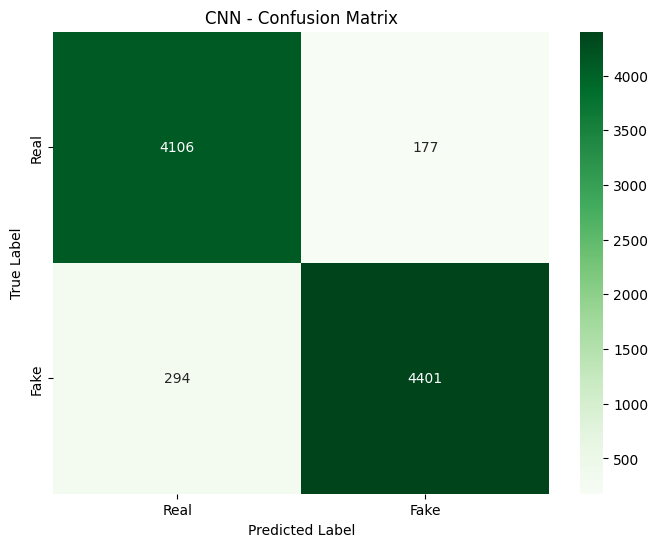


CNN Results: {'test_loss': 0.13370104292072058, 'test_accuracy': 0.9475384272666518, 'test_f1': 0.9475609156959364, 'test_precision': 0.9479053392943768, 'test_recall': 0.9475384272666518}


In [28]:
cnn_model.load_state_dict(torch.load('best_cnn_model.pth'))

print("\nEvaluating CNN model on test set:")
test_loss, test_acc, test_f1, test_preds, test_labels = evaluate(
    cnn_model, test_loader, criterion, device
)

print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Accuracy: {test_acc:.4f}")
print(f"  F1-Score: {test_f1:.4f}")

print("\nClassification Report:")
print(classification_report(test_labels, test_preds, target_names=['Real', 'Fake']))

# Confusion Matrix
cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.title('CNN - Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

cnn_results = {
    'test_loss': float(test_loss),
    'test_accuracy': float(test_acc),
    'test_f1': float(test_f1),
    'test_precision': float(precision_score(test_labels, test_preds, average='weighted')),
    'test_recall': float(recall_score(test_labels, test_preds, average='weighted'))
}

print(f"\nCNN Results: {cnn_results}")



## Download Model for Railway Deployment

After training, download the best CNN model file for deployment on Railway.


In [29]:
# Download CNN model for Railway deployment
from google.colab import files
import os

model_path = 'best_cnn_model.pth'

if os.path.exists(model_path):
    print(f"✓ Model file found: {model_path}")
    print(f"  File size: {os.path.getsize(model_path) / (1024*1024):.2f} MB")

    # Download the file
    files.download(model_path)

    print("\n" + "="*60)
    print("✓ MODEL DOWNLOADED!")
    print("="*60)
    print("\nNext steps:")
    print("1. The best_cnn_model.pth file should be downloaded to your Downloads folder")
    print("2. Copy it to the models/ folder in your project")
    print("3. The path should be: Fake-News-Classifier-2/models/best_cnn_model.pth")
else:
    print(f"⚠ Warning: Model file not found at {model_path}")
    print("Make sure training has been completed successfully.")


✓ Model file found: best_cnn_model.pth
  File size: 7.45 MB


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ MODEL DOWNLOADED!

Next steps:
1. The best_cnn_model.pth file should be downloaded to your Downloads folder
2. Copy it to the models/ folder in your project
3. The path should be: Fake-News-Classifier-2/models/best_cnn_model.pth
